In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn


In [8]:
df = pd.read_csv('T1.csv')

## Exploratory Data Analysis

In [9]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [10]:
# Now I want to see if there are useless values in the dataset, values that I may have to clean

#First, I will be checking for null values
df.isnull().value_counts()

Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  Wind Direction (°)
False      False                False             False                          False                 50530
dtype: int64

In [11]:
# I don't have any null values, now I will check if the values that I have are reasonable
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [13]:
# The values seem to be reasonable, with the only issue being that the minimum value for LV Active Power is negative,
# which would theoretically mean that the turbine is absorving active power.
# As I am interested in the behaviour of the active power accross the months, I will divide the data in year, month and day

df[['Day', 'Month', 'Year', 'Time']] = df['Date/Time'].str.split(expand = True)

In [14]:
df[['Year', 'Month', 'Day']] = df[['Year', 'Month', 'Day']].astype(int)

In [15]:
df.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Day', 'Month',
       'Year', 'Time'],
      dtype='object')

In [16]:
df.drop(['Year','Time', 'Date/Time'], axis=1, inplace=True)

<AxesSubplot:>

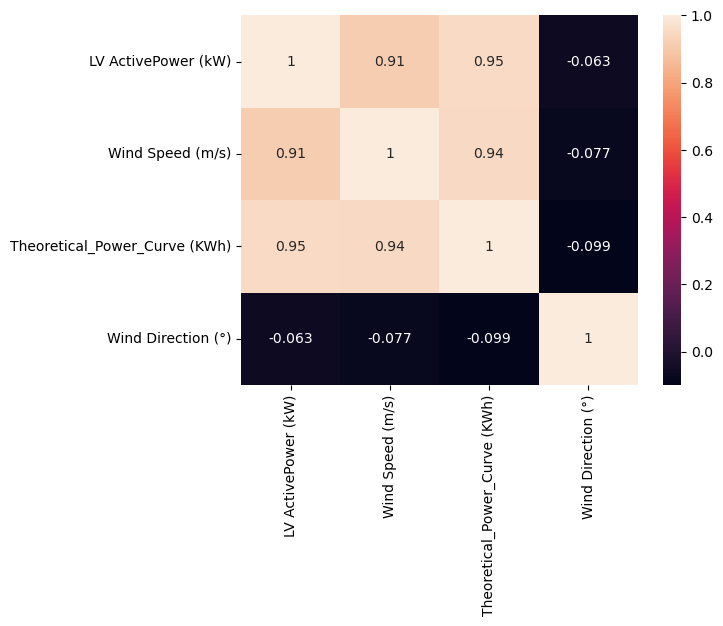

In [17]:
# Now, I want to see the correlation matrix. As a hypothesis, I can state that the power will be high when the wind is around 14 m/s.
corr = df[['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']].corr()
sn.heatmap(corr, annot=True)

In [18]:
# Now, I want to plot the distribution of the LV Active power, in relation to every other variable

In [19]:
columns = df.columns.to_list()
columns_to_remove = ['LV ActivePower (kW)', 'Month', 'Day']
columns = [col for col in columns if col not in columns_to_remove]


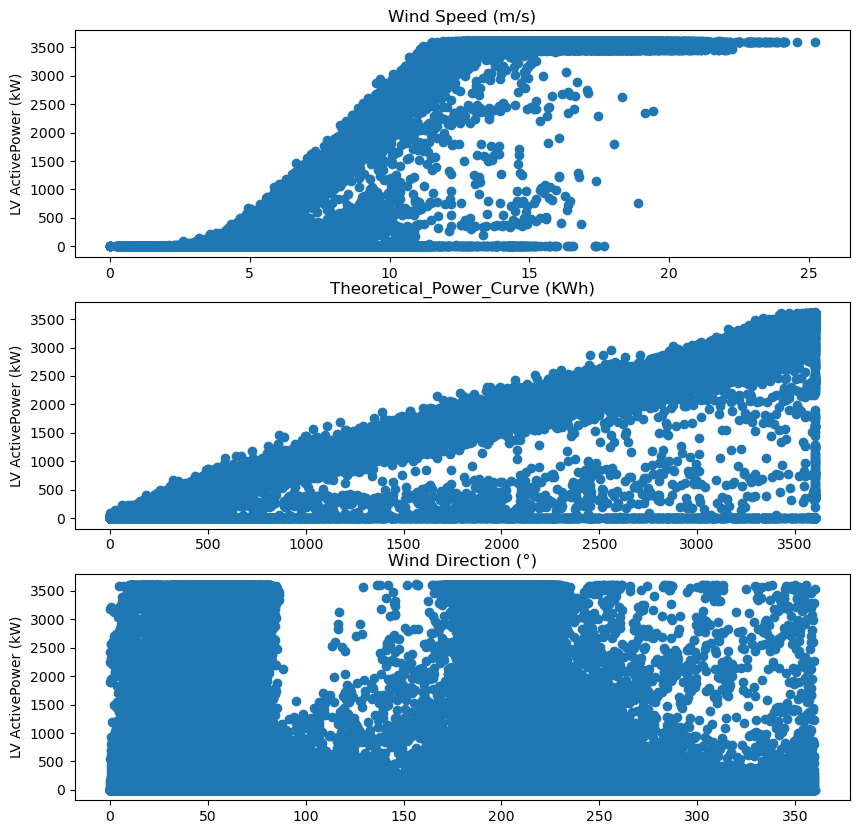

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
for i in range(0,len(columns)):
    axs[i].scatter(df[columns[i]], df['LV ActivePower (kW)'])
    axs[i].set_title(columns[i])
    axs[i].set_ylabel('LV ActivePower (kW)')
    

From this we have learnt a couple of things:
- The LV Active Power saturates at wind speed around 12 m/s, as we had predicted in the hypothesis
- The power dramatically decreases with wind directions of around 100 and 320 degrees
- As expected, active power is always lower or equal the theoretical power

In [23]:
type(df.groupby('Month').mean('LV ActivePower (kW)'))

pandas.core.frame.DataFrame

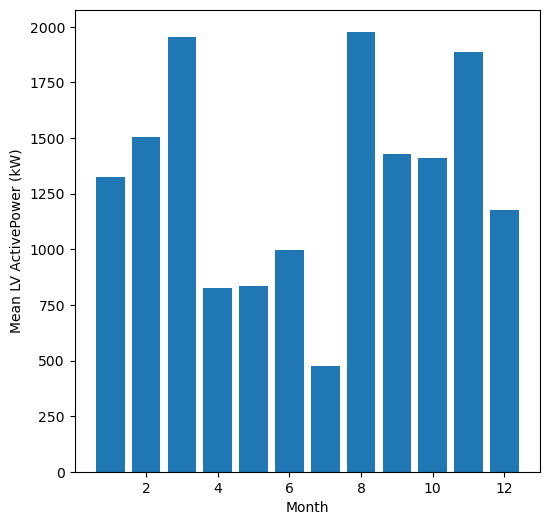

In [24]:
# We will now calculate the average power per month, and plot it in a barplot. This won't provide any new information,
# as power depends on wind conditions, not on months. If we had more years, we could determine if some months have 
# a predisposition to have better winds.
fig, ax = plt.subplots(figsize=(6, 6))
monthly_means = df.groupby('Month')['LV ActivePower (kW)'].mean()
ax.bar(monthly_means.index, monthly_means.values)
ax.set_xlabel('Month')
ax.set_ylabel('Mean LV ActivePower (kW)')
plt.show()

We can see that it looks like energy production decreases in summer months, and this could imply that this location is in the northern hemisphere, where winds tend to me weaker in the June-August months, summer in the northern hemisphere. This
hypothesis is right, as this data comes from a turbine in Turkey.

Now, I will perform an analysis using histograms to explore the frequency distributions of the data.
We know that the wind speeds tend to follow a Weibull distribution, so we expect to see that kind of shape in the wind speed's histogram


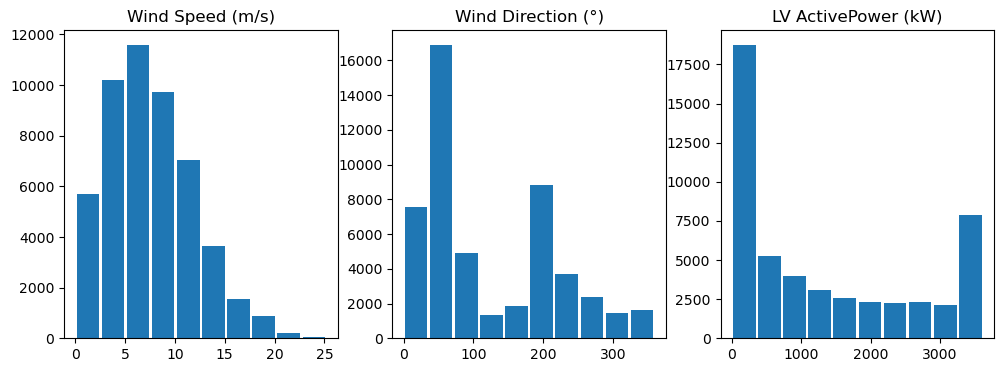

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].hist(df['Wind Speed (m/s)'], bins=10, rwidth=0.9)
axs[0].set_title('Wind Speed (m/s)')

axs[1].hist(df['Wind Direction (°)'], bins=10, rwidth=0.9)
axs[1].set_title('Wind Direction (°)')

axs[2].hist(df['LV ActivePower (kW)'], bins=10,rwidth=0.9)
axs[2].set_title('LV ActivePower (kW)')
plt.show()

We will now create a Wind-Rose, which will give us the direction and speeds of the wind related to power production. This is a very visual representation of the behavior of the turbine.

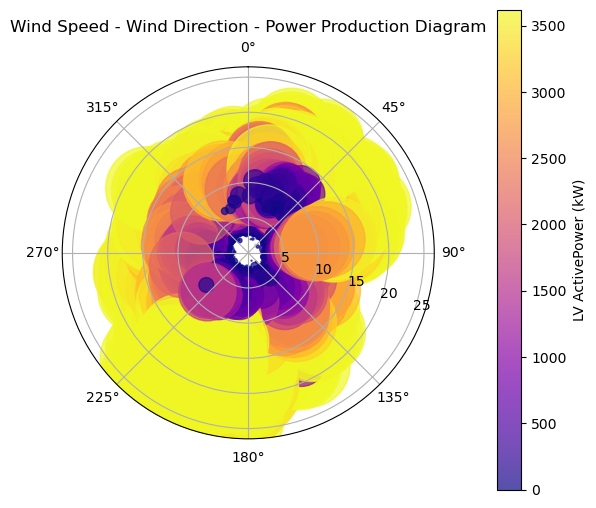

In [41]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(projection='polar')

# Convert wind direction to radians
wind_dir_rad = np.radians(df['Wind Direction (°)'])

# Scatter plot
scatter = ax.scatter(wind_dir_rad, df['Wind Speed (m/s)'], s=df['LV ActivePower (kW)'],
                      c=df['LV ActivePower (kW)'], alpha=0.7, cmap='plasma')

# Set the polar diagram's top to represent the North
ax.set_theta_zero_location('N')

# Set -1 to start the wind direction clockwise
ax.set_theta_direction(-1)

# Set wind speed labels in a better position to see
ax.set_rlabel_position(110)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('LV ActivePower (kW)')
cbar.ax.set_position([0.85, 0.1, 0.05, 0.8])
# Set title and remove y-label
plt.title('Wind Speed - Wind Direction - Power Production Diagram')
plt.ylabel(None)

plt.show()

Insights gained:
- Power production decreases when the wind blows in the directions of 120 and 320 degrees.
- The turbine produces less power during the summer months (April-August), as the winds are weaker during this time.
- The power production saturates at around 14 m/s

# Building of the model

Once that the exploratory analysis has been carried out, we are going to build a model to predict the power production from the available data. In the exploratory analysis, we have seen that there is a causation between the Wind Speeds and Direction and the Power production, so those are the features that we are going to use.
In this case, I have a relatively small dataset with two features and an output variable that you want to predict. 

First of all I will try polynomic regression, which should follow the edge of the power distribution, the part that represents the theoretical power. However, it won't do a good job when the turbine is giving less power than expected.

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



In [238]:
X_train, X_test, y_train, y_test = train_test_split(df[["Wind Speed (m/s)", 'Wind Direction (°)']], df['LV ActivePower (kW)'], test_size=0.2)



In [240]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4, include_bias=False)
X_train_poly = poly.fit_transform(X_train.to_numpy())
X_test_poly = poly.fit_transform(X_test.to_numpy())

clf = LinearRegression()
clf.fit(X_train_poly, y_train)

LinearRegression()

In [241]:
y_pred_poly = clf.predict(X_test_poly)

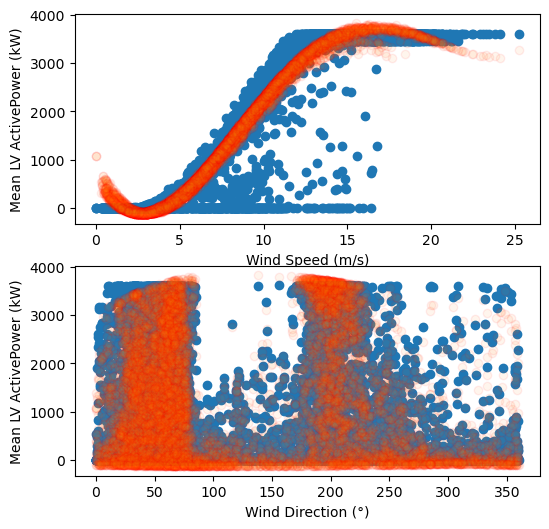

In [242]:

fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].scatter(X_test['Wind Speed (m/s)'],y_test)
ax[0].scatter(X_test['Wind Speed (m/s)'],y_pred_poly, color=None, alpha=0.07, edgecolors = 'red')
ax[0].set_xlabel('Wind Speed (m/s)')
ax[0].set_ylabel('Mean LV ActivePower (kW)')

ax[1].scatter(X_test['Wind Direction (°)'],y_test)
ax[1].scatter(X_test['Wind Direction (°)'],y_pred_poly, color=None, alpha=0.07, edgecolors = 'red')
ax[1].set_xlabel('Wind Direction (°)')
ax[1].set_ylabel('Mean LV ActivePower (kW)')
plt.show()

In [251]:
mse_poly = mean_squared_error(y_test, y_pred_poly)
print('The MSE of the Polynomial Regression is:', mse_poly)

The MSE of the Polynomial Regression is: 166273.33464153475


Now, I will try a Random Forest Regressor

In [244]:

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [245]:
y_pred_RF = regr.predict(X_test)

regr.score(X_test, y_pred_RF, sample_weight=None)


1.0

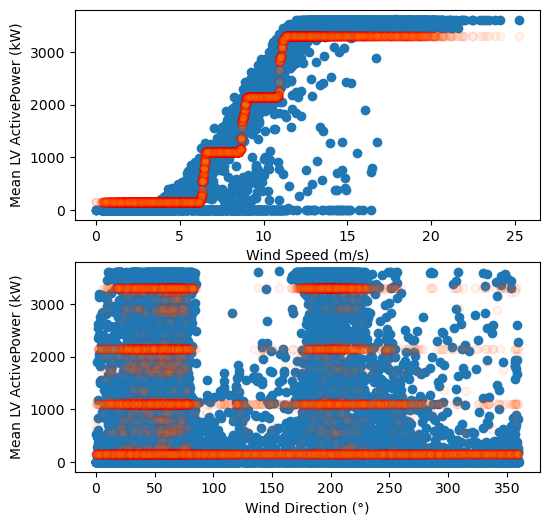

In [246]:

fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].scatter(X_test['Wind Speed (m/s)'],y_test)
ax[0].scatter(X_test['Wind Speed (m/s)'],y_pred_RF, color=None, alpha=0.07, edgecolors = 'red')
ax[0].set_xlabel('Wind Speed (m/s)')
ax[0].set_ylabel('Mean LV ActivePower (kW)')

ax[1].scatter(X_test['Wind Direction (°)'],y_test)
ax[1].scatter(X_test['Wind Direction (°)'],y_pred_RF, color=None, alpha=0.07, edgecolors = 'red')
ax[1].set_xlabel('Wind Direction (°)')
ax[1].set_ylabel('Mean LV ActivePower (kW)')
plt.show()

In [247]:
mse_RF = mean_squared_error(y_test, y_pred_RF)
print('The MSE of the Random Forest Regression is:', mse_RF)

The MSE of the Random Forest Regression is: 201272.28227471525


The Random Forest Model is no good in this case, as it struggles to represent the non linearity of data, it can't, with these little features. Here, as I have a relatively small dataset with non-linear relationships, and I want a model with high accuracy and less overfitting, then GBR may be a better choice, so, I am going to build a Gradient Boosting Regressor.

In [252]:
GBRregr = GradientBoostingRegressor(random_state=0)
GBRregr.fit(X_train, y_train)
y_pred_GBR = GBRregr.predict(X_test)
GBRregr.score(X_test, y_pred_RF, sample_weight=None)


0.963554570323238

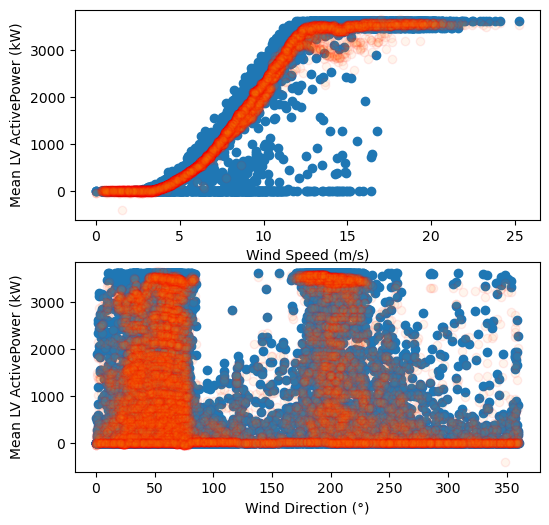

In [253]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].scatter(X_test['Wind Speed (m/s)'],y_test)
ax[0].scatter(X_test['Wind Speed (m/s)'],y_pred_GBR, color=None, alpha=0.07, edgecolors = 'red')
ax[0].set_xlabel('Wind Speed (m/s)')
ax[0].set_ylabel('Mean LV ActivePower (kW)')

ax[1].scatter(X_test['Wind Direction (°)'],y_test)
ax[1].scatter(X_test['Wind Direction (°)'],y_pred_GBR, color=None, alpha=0.07, edgecolors = 'red')
ax[1].set_xlabel('Wind Direction (°)')
ax[1].set_ylabel('Mean LV ActivePower (kW)')
plt.show()

In [254]:
mse_GBR = mean_squared_error(y_test, y_pred_GBR)
print('The MSE of the Gradient Boosting Regressor is:', mse_GBR)

The MSE of the Gradient Boosting Regressor is: 146009.63688506448


The best model has been achieved using the Gradient Boosting Regressor, as it is the one that best adapts to the non linearity of the data, while representing some of the non optimal behaviour of the turbine.